## Evaluation of how well we can use pre-trained movie embeddings to predict user ratings/ make recommendations


In [24]:
from movie_recommender import movies_similar_to
import numpy as np
import pandas as pd
import pickle 

In [25]:
# Load embeddings
with open('G:/My Drive/DublinAI/Mini Projects/chatbot/nn/embeddings_smaller', 'rb') as file:
    embed, movie_to_index = pickle.load(file)

# Load validation data 
ratings = pd.read_csv('G:/My Drive/DublinAI/Mini Projects/chatbot/extra_data/ml-latest/ratings_more.csv',low_memory=False)
ratings_small = ratings.iloc[:-(len(ratings)-10000)].copy()
ratings_small['newId'] = ratings_small['movieId'].map(movie_to_index)
ratings_small = ratings_small.dropna(subset=['newId'])
print(ratings_small.head())

   userId  movieId  rating   timestamp   newId
0       1      307     3.5  1256677221   493.0
1       1      481     3.5  1256677456   883.0
2       1     1091     1.5  1256677471  1082.0
3       1     1257     4.5  1256677460  1092.0
4       1     1449     4.5  1256677264   569.0


In [26]:
# Check to make sure movies in ratings dataset are also in our main database
df = pd.read_csv('./the-movies-dataset/df_prep.csv',low_memory=False)
to_keep = ratings_small.movieId.apply(lambda x: x in df['movieId'])
ratings_small=ratings_small[to_keep]
print(ratings_small.shape)

(5928, 5)


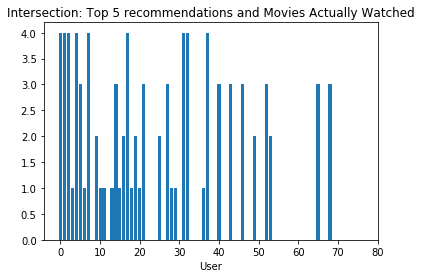

In [39]:
def calculate_distance(base,array):
    rep_base = np.tile(base,(array.shape[0],1)) # python
    rep_base_norm = np.sqrt((rep_base**2).sum(axis=1))
    array_norm = np.sqrt((array**2).sum(axis=1))
    c = np.multiply(rep_base,array).sum(axis=1)/(rep_base_norm*array_norm)
    return c

# predict ratings using embeddings - 1/dist
def predict_rating(ratings,n_train=15,n_test=5):
    a = ratings.userId.value_counts()
    unique_users = a[0:(ratings.userId.value_counts()>(n_train+n_test)).sum()].index
    n_users = unique_users.shape[0]
    final_loss = np.zeros((n_users,1))
    for i in range(n_users):
        indices = list(ratings.index[ratings.userId == unique_users[i]])
        r_i = np.asarray(ratings.rating[indices[:n_train]])
        v_i = list(map(int,list(ratings.newId[indices[:n_train]])))
        count = 0
        predictions = np.zeros((n_test,1))
        ground_truth = np.asarray(ratings.rating[indices[n_train:n_train+n_test]])
        for j in range(n_train,n_train+n_test):
            idx = ratings.newId[indices[j]]
            b = 1/calculate_distance(embed[int(idx)],embed[v_i])
            b[b<0]=0
            if b.sum()>0:
                b = b/b.sum()
                predictions[count]=(b*r_i).sum()
            else:
                predictions[count]=r_i.mean()
            count += 1
        final_loss[i] = np.sqrt(np.mean((predictions - ground_truth)**2))
# current movie rating = distance of current movie from n-1
    return unique_users, final_loss

# how likely is a suggested movie to be one the user actually opted to watch
# k most similar to n previous movies
# overlap with the k actual movies
def precision_k(ratings, n_train, k=5):
    '''Return precision and recall at k metrics for each user.'''
    a = ratings.userId.value_counts()
    unique_users = a[0:(ratings.userId.value_counts()>(n_train+k)).sum()].index
    n_users = unique_users.shape[0]
    precision = np.zeros((1,n_users))
    for i in range(n_users):
        indices = list(ratings.index[ratings.userId == unique_users[i]])
        v_i = list(map(int,list(ratings.newId[indices[:n_train]])))
        mapped_indices = [int(df.index[df.newId==j][0]) for j in v_i if df.index[df.newId==j].shape[0]>0]
        entity = [0,mapped_indices]
        _, ids = movies_similar_to(entity,k,genre='all',method = 'collab',exclude_collection = False)
        predicted_films = set(np.asarray(df.newId[ids]))
        ground_truth =  set(ratings.newId[indices[n_train:]])
        precision[0][i] = len(list(predicted_films.intersection(ground_truth)))
# current movie rating = distance of current movie from n-1
    return unique_users, precision

unique_users, precision = precision_k(ratings_small,5,k=5)

import matplotlib.pyplot as plt
x_pos = [i for i, _ in enumerate(precision[0])]
plt.bar(x_pos,precision[0],)
plt.xlabel("User")
plt.title("Intersection: Top 5 recommendations and Movies Actually Watched")
plt.show()